<a href="https://colab.research.google.com/github/BanyanLiu/titanic-analysis2/blob/main/%E5%B0%88%E9%A1%8C%E5%AF%A6%E4%BD%9C_%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E5%AD%98%E6%B4%BB%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt


In [9]:
data = pd.read_csv("https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [20]:
# 和是否生還相關性高的欄位
x = data.drop(["Name","Ticket","Cabin","Embarked","Survived","Age"], axis=1)
x["Sex"],_ = x["Sex"].factorize() # 把姓別從類別資料轉為數值資料
y = data[["Survived"]]

#計算每一欄有多少缺失值
per_col_missing = x.isnull().sum()
total_missing = per_col_missing.sum()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<BarContainer object of 6 artists>

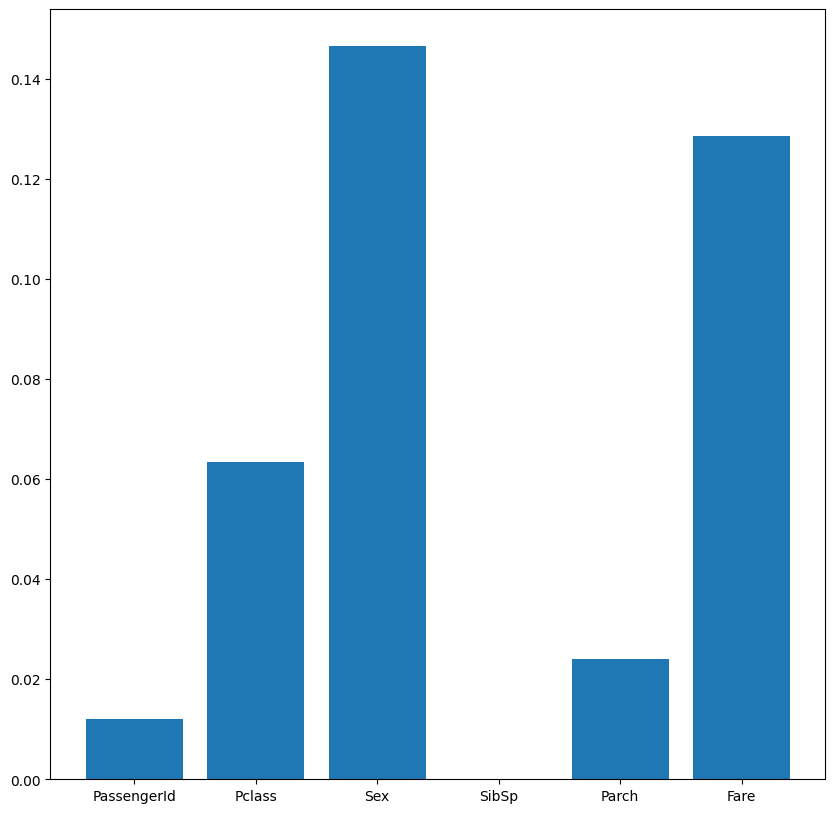

In [65]:
# 計算mutual information
select = mutual_info_regression(x,y)
select = pd.DataFrame(select,index = x.columns, columns = ["MI"])
select["MI"].sort_values(ascending = True)

#把計算出來的mutual information畫出來
figure, axes = plt.subplots(figsize = (10,10))
axes.bar(select.index,select["MI"])

<ipython-input-64-605675b842f2>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  only_survive = data.dropna()[data["Survived"]==1]


<BarContainer object of 51 artists>

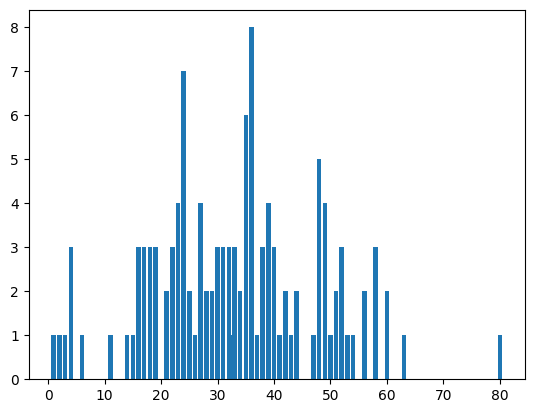

In [64]:
#畫age和survive的關係圖
only_survive = data.dropna()[data["Survived"]==1]
only_survive_s = only_survive.groupby("Age", as_index=False)["Survived"].value_counts()
only_survive_s = pd.DataFrame(only_survive_s)
plt.bar(only_survive_s["Age"], only_survive_s["count"])
#在groupby的指令中加入as_index，是為了指定是否讓分組欄位當作索引值，False表示會不會讓分組欄位當作索引值

In [36]:
#和是否存活這個變數相關性高的參數有Pclass, sex, Parch, Fare